In [1]:
import math
import torch
import gpytorch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm_notebook
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_excel('points.xlsx')

In [3]:
data.head()

,Shear rate,ppm,Viscosity
0,7.835758,10,1.683102
1,12.762008,10,1.486875
2,20.587486,10,1.414947
3,33.530600,10,1.380299
4,54.610900,10,1.313526


In [4]:
x = data.drop('Viscosity', axis=1).values
y = data.Viscosity.values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [6]:
train_x = torch.tensor(x_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [8]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 10000
for i in trange(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.log_lengthscale.item(),
#         model.likelihood.log_noise.item()
#     ))
    optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:07<00:00, 53.31it/s]


In [9]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

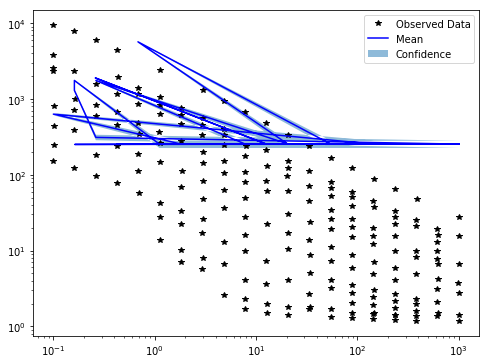

In [10]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.loglog(train_x.numpy()[:, 0], train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.loglog(test_x.numpy()[:, 0], observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy()[:, 0], lower.numpy(), upper.numpy(), alpha=0.5)

    ax.legend(['Observed Data', 'Mean', 'Confidence'])